# Generating figures, tables and supplementary material

**Authored by:** Yicheng Zhu, Cheng Soon Ong and Gavin Huttley

This notebook produces the figures and tables for the main manuscript and the supplementary material. It assumes the directory containing the manuscript latex is named `mutation_classifier_manuscript` and is a sister directory to the one containing this file.

The notebook further assumes installation of numerous python libraries. Those are defined in the top level imports below.

In [1]:
%matplotlib inline
from warnings import filterwarnings

# suppressing the multitude of future and user warnings from the graphics libraries
filterwarnings("ignore", category=Warning)

import os, itertools, glob, json, shutil, operator
from itertools import permutations, combinations
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd

from cogent3 import LoadTable, DNA

from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mutation_motif import util, logo
from mutation_motif.mutation_analysis import get_single_position_fig, single_position_effects, get_selected_indices
from mutation_motif.height import get_re_char_heights
from mutation_motif.draw import get_plot_data, format_float, draw_spectrum_grid

In [2]:
def get_auc(directory, sample_aucs, clf):
    """return the average classification auROC score in specified directory"""
    data_files = glob.glob(os.path.join(directory + 'sample_*/%s/classification_report.json' % clf))
    train_size = int(directory.split('/')[-2].split('_')[-1])
    dimension = int(directory.split('/')[-3].split('_')[0])
    
    for file in data_files:
        json_data=open(file).read()
        data = json.loads(json_data)
        #sample_idx = file.split('/')[7]
        auc_score = data["auROC"]
        sample_aucs.append([dimension, train_size, auc_score, clf])
     
    return sample_aucs

def format_positions(positions):
    positions = positions.split(":")
    old_new = {"0": "-2", "1": "-1", "2": "+1", "3": "+2"}
    redone = [old_new[p[-1]] for p in positions]
    if len(redone) == 1:
        template = "%s"
    else:
        template = "(%s)"
    
    return template % ", ".join(redone)

def format_direction(direction):
    direction = direction.replace('to', r'$\rightarrow$')
    return direction

def format_group(group):
    group_dict = {'ENU_variants':'ENU', 'germline_variants':'Spontaneous'}
    group = group.split('/')[7]
    return group_dict[group]

def format_pvalue(value):
    """0.0 if 0, float if <= 0.0001, scientific otherwise"""
    epsilon = 1e-6
    if value <= 1e-100:
        result = "0.0"
    elif 1-epsilon <= value <= 1.0+epsilon:
        result = "1.0"
    elif 1e-4 <= value:
        result = "%.4f" % value
    elif 0 < value < 1e-4:
        result = latex_format_numbers(value)
    else:
        raise ValueError(value)
    return result

def latex_format_numbers(value):
    try:
        value = float(value)
    except ValueError:
        return value
    
    if value == 0:
        return "0"
    v = "%.1e" % value
    v = v.split("e")
    v[1] = str(int(v[1]))
    v = r"$%s\times 10^{%s}$" % tuple(v)
    return v

table_template = "\\begin{table}[htp]\n\\centering\n%s\n\end{table}\n"

def format_latex_table(table, justify, label=None):
    caption = table.title or ""
    table.title = ""
    label = label or ""
    result = table_template % table.tostring(format="latex", justify=justify)
    result = result.replace("longtable", "tabular").replace("[htp!]", "")
    
    if caption:
        caption = r"\caption{%s}" % caption
    
    if label:
        caption += r"\label{%s}" % label
    
    if caption:
        result = result.splitlines()
        result.insert(-1, caption)
        result = "\n".join(result)
    
    return result

model_nm_dict = {0:"M", 1:"M+I", 2:"M+I+2D", 3:"M+I+3D", 4:"M+I+4D", 5:"M+I+5D", 6:"FS"}

#### Create a directory `figs_n_tabs`

In [3]:
!mkdir -p figs_n_tabs

# Manuscript figures and tables

In [4]:
all_ms_tables = []
all_ms_tab_dict = {}
all_supp_dict = {}

## Figures 

### Figure: mutation motif analysis of neighbourhood effects, figure showing ENU, spontaneous 

In [5]:
!mutation_draw grid --fig_config loglin/scripts/logo_grid_draw.cfg --figpath figs_n_tabs/mm_ENU_v_germline.pdf --format pdf
!rm figs_n_tabs/mm_ENU_v_germline.log
print("figs_n_tabs/mm_ENU_v_germline.pdf is saved.")

/bin/sh: mutation_draw: command not found
rm: figs_n_tabs/mm_ENU_v_germline.log: No such file or directory
figs_n_tabs/mm_ENU_v_germline.pdf is saved.


## Table: summary of hypotheses testing comparing the two groups

In [6]:
fns = !ls loglin/results/ENU_vs_germline/autosomes/directions/AtoG/summary.txt
tab_enu_v_sp = LoadTable(fns[0], sep="\t")
tab_enu_v_sp = tab_enu_v_sp.with_new_column("Position(s)", format_positions, columns=["Position"])
tab_enu_v_sp = tab_enu_v_sp.get_columns(["Position(s)", "Deviance", "df", "prob"])
tab_enu_v_sp = tab_enu_v_sp.with_new_header("prob", "p-value")
tab_enu_v_sp.format_column("p-value", format_pvalue)
tab_enu_v_sp.format_column("Deviance", "%.1f")
tab_enu_v_sp = tab_enu_v_sp.sorted(columns=["df", "Deviance"])

tab_enu_v_sp.title = r"Log-linear analysis of mutation motif comparison between mouse germline and ENU-induced "\
+r"A$\rightarrow$G mutations. Deviance is from the log-linear model, with df degrees-of-freedom "\
+r"and corresponding $p$-value obtained from the $\chi^2$ distribution."

label = "table:enu_v_germline:a-g"
all_ms_tables.append(format_latex_table(tab_enu_v_sp, justify="rrrl", label=label))
all_ms_tab_dict[label] = tab_enu_v_sp
tab_enu_v_sp

+2,88.6,3,$4.4\times 10^{-19}$
-2,1105.6,3,0.0
+1,1393.7,3,0.0
-1,5693.3,3,0.0
"(-2, +2)",12.0,9,0.2145
"(-1, +2)",50.3,9,$9.4\times 10^{-8}$
"(+1, +2)",96.1,9,$9.5\times 10^{-17}$
"(-2, +1)",123.0,9,$3.3\times 10^{-22}$
"(-2, -1)",284.1,9,$6.2\times 10^{-56}$
"(-1, +1)",353.1,9,$1.3\times 10^{-70}$
"(-2, -1, +2)",41.2,27,0.0396


## Figure: 7-mer learning curve indicates M+I+2D is sufficient

figs_n_tabs/7mer_learning_curve.pdf is saved!


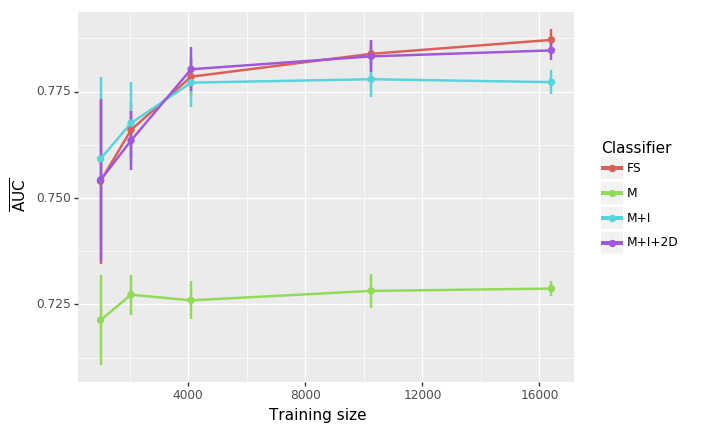

<ggplot: (-9223372036569210564)>


In [7]:
lc_aucs_7mer = []
dims = [0,1,2,6]    

for dim in dims:
    data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_*/" % dim)
    
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'LR')
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        lc_aucs_7mer.append([model_nm_dict[dim], train_size, auc])

models = set(r[0] for r in lc_aucs_7mer)
train_sizes = set(r[1] for r in lc_aucs_7mer)
n = 5

lc_auc_records = []
for model in models:
    for train_size in train_sizes:
        auc_list = []
        for r in lc_aucs_7mer:
            if model not in r:
                continue
            if train_size not in r:
                continue
            auc_list.append(r[2])
            
        auc_mean = np.array(auc_list).mean()
        auc_se = np.array(auc_list).std(ddof=1)
        
        lc_auc_records.append([model, train_size, auc_mean, auc_se]) 

h = ['Classifier', 'Training_size', 'Mean_AUC', 'Std_error']
lc_tab = LoadTable(header=h, rows=lc_auc_records).to_pandas_df()
lc_fig = (ggplot(lc_tab) +
     aes(x="Training_size", y="Mean_AUC", colour="Classifier") +
     geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
     geom_line(size=1) +
     geom_point(size=2) +
     labs(x="Training size", y="$\overline{\mathrm{AUC}}$")
       )

outname = "figs_n_tabs/7mer_learning_curve.pdf"
lc_fig.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lc_fig)       

## Figure: faceted plot comparing mean AUC between k-mer samples

figs_n_tabs/kmer_comparison.pdf is saved!


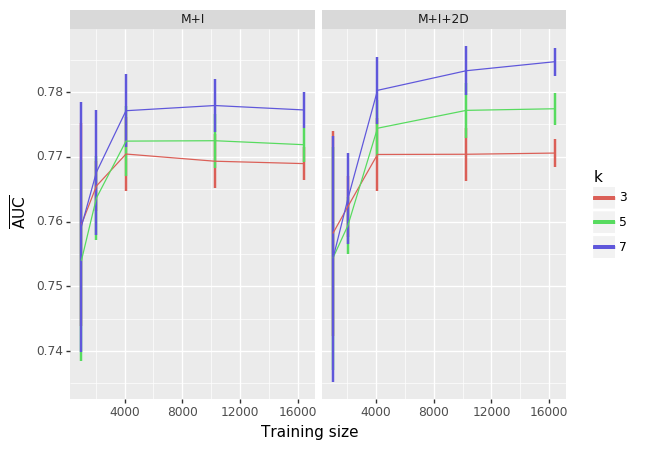

<ggplot: (-9223372036566999471)>


In [8]:
window_sizes = [3, 5, 7]
dims = [0, 1, 2]
train_sizes = [1009, 2050, 4101, 10255, 16408]

plot_rows = []
for dim in dims:
    for ws in window_sizes:
        for ts in train_sizes:
            data_dirs = glob.glob("classifier/results/chrom1/%s-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (ws, dim, ts))
            for directory in data_dirs:
                aucs = get_auc(directory, [], 'LR')
                auc_list = [r[2] for r in aucs]
                auc_mean = np.array(auc_list).mean()
                auc_se = np.array(auc_list).std(ddof=1)
                model_name = model_nm_dict[dim]
                if model_name == "M":
                    continue  # we ignore this since the results are identical for all k
                plot_rows.append([model_name, '%s' % ws, ts, auc_mean, auc_se])

plot_header = ['Classifier_design', 'k', 'Train_size', 'Mean_AUC', 'Std_error']
faceted_tab = LoadTable(header=plot_header, rows=plot_rows).to_pandas_df()
faceted_plot = (ggplot(faceted_tab) +
                aes(x='Train_size', y='Mean_AUC', colour='k', group='k') + 
                geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
                geom_line() + 
                labs(x="Training size", y="$\overline{\mathrm{AUC}}$") +
                facet_wrap(' ~ Classifier_design')
               )

outname = "figs_n_tabs/kmer_comparison.pdf"
faceted_plot.save(outname, units="cm", width=20, height=9)
print ("%s is saved!" % outname)
print (faceted_plot)

## Figure: Bar chart showing distributions of LR AUC from all chromosomes using M+I+2D with window size of 7 bp

figs_n_tabs/all_lr_aucs_bars.pdf is saved!


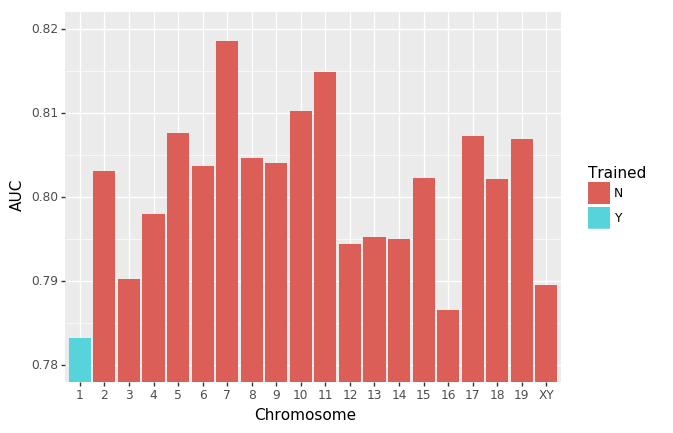

<ggplot: (-9223372036566819040)>
mean(AUC)=0.801  std(AUC)=0.009


In [9]:
all_chroms = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'XY']

bar_chart_records = []
for chrom in all_chroms:
    if chrom is 1:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_10255/")
        trained = 'Y'
    else:
        data_dirs = glob.glob("classifier/results/chrom%s/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_0/" % chrom)
        trained = 'N'
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'LR')
    auc_list = [r[2] for r in aucs]
    auc_mean = np.array(auc_list).mean()
    #auc_se = np.array(auc_list).std(ddof=1)
    bar_chart_records.append([auc_mean, chrom, trained, 'LR'])

bar_chart_header = ['AUC_mean', 'Chromosome', 'Trained', 'Classifier']
lr_bar_chart_tab = LoadTable(header=bar_chart_header, rows=bar_chart_records).to_pandas_df().sort_values('AUC_mean')
lr_bar_chart = (ggplot(aes(x='Chromosome', y="AUC_mean", fill="Trained"), data=lr_bar_chart_tab) + \
                labs(x="Chromosome", y="AUC") + \
                geom_bar(stat="identity") + coord_cartesian(ylim=(0.78, 0.82)) + \
                scale_x_discrete(limit='AUC_mean'))
outname = "figs_n_tabs/all_lr_aucs_bars.pdf"
lr_bar_chart.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lr_bar_chart)
print("mean(AUC)=%.3f  std(AUC)=%.3f" % (lr_bar_chart_tab['AUC_mean'].mean(), lr_bar_chart_tab['AUC_mean'].std(ddof=1)))

## Figure: Bar chart showing one-class classification AUC for all chromosomes using M+I+2D with window size of 7 bp

figs_n_tabs/all_ocs_aucs_bars.pdf is saved!


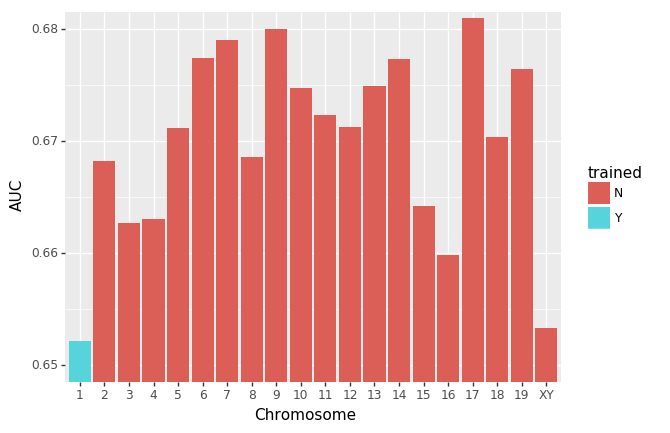

<ggplot: (287325767)>
mean(AUC)=0.670  std(AUC)=0.008


In [10]:
all_chroms = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'XY']

bar_chart_records = []
for chrom in all_chroms:
    if chrom is 1:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_10255/")
        trained = 'Y'
    else:
        data_dirs = glob.glob("classifier/results/chrom%s/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_0/" % chrom)
        trained = 'N'
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'OCS')
    
    auc_list = [r[2] for r in aucs]
    auc_mean = np.array(auc_list).mean()
    #auc_se = np.array(auc_list).std(ddof=1)
    bar_chart_records.append([auc_mean, chrom, trained, 'OC'])


bar_chart_header = ['AUC_mean', 'Chromosome', 'trained', 'Classifier']
ocs_bar_chart_tab = LoadTable(header=bar_chart_header, rows=bar_chart_records).to_pandas_df()
ocs_bar_chart = (ggplot(aes(x='Chromosome', y="AUC_mean", fill="trained"), data=ocs_bar_chart_tab) + \
             labs(x="Chromosome", y="AUC") + \
             geom_bar(stat="identity") + coord_cartesian(ylim=(0.65, 0.68))) 

outname = "figs_n_tabs/all_ocs_aucs_bars.pdf"
ocs_bar_chart.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (ocs_bar_chart)
print("mean(AUC)=%.3f  std(AUC)=%.3f" % (ocs_bar_chart_tab['AUC_mean'].mean(), ocs_bar_chart_tab['AUC_mean'].std(ddof=1)))

figs_n_tabs/all_lr_vs_ocs_aucs.pdf is saved!


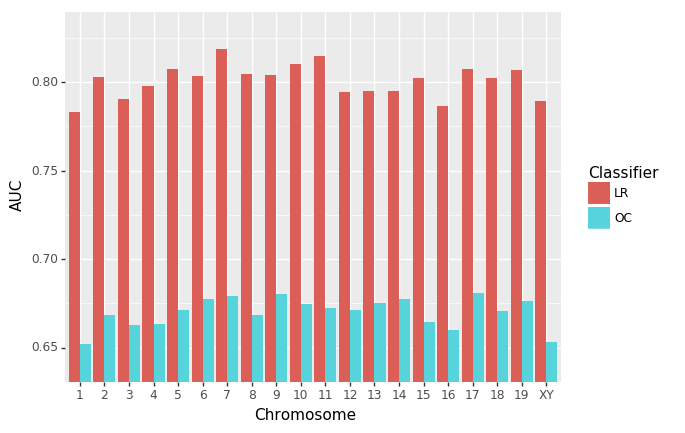

<ggplot: (-9223372036567446668)>


In [11]:
merged_bar_chart_tab = pd.concat([lr_bar_chart_tab, ocs_bar_chart_tab])
lvo_bar_chart = (ggplot(aes(x='Chromosome', y="AUC_mean", fill="Classifier"), data=merged_bar_chart_tab) + \
             labs(x="Chromosome", y="AUC") + \
             geom_bar(stat="identity", position = "dodge") + coord_cartesian(ylim=(0.64, 0.83)))

outname = "figs_n_tabs/all_lr_vs_ocs_aucs.pdf"
lvo_bar_chart.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lvo_bar_chart)

## Figure: One class classification results summary for 7-mer experiments

figs_n_tabs/oc_learning_curve.pdf is saved!


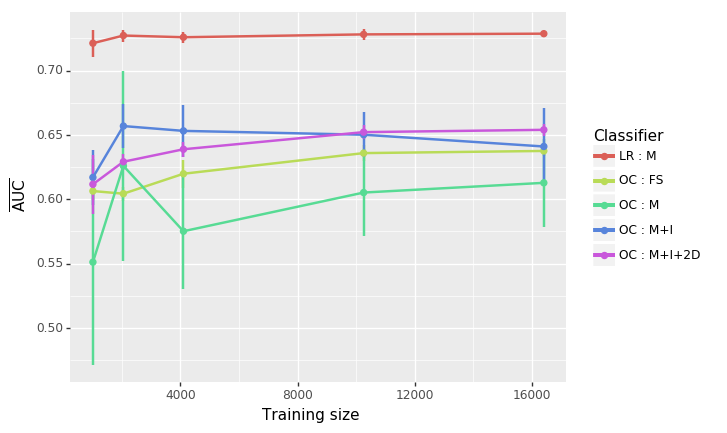

<ggplot: (288320502)>

In [12]:
ocs_aucs_7mer = []
dims = [0,1,2,6]    

for dim in dims:
    data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_*/" % dim)
    
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'OCS')
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        ocs_aucs_7mer.append(['OC : %s' % model_nm_dict[dim], train_size, auc])

lr_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/0_way_samples/train_size_*/")
sample_aucs = []
for lr_dir in lr_dirs:
    lr_aucs = get_auc(lr_dir, sample_aucs, 'LR')
sort_lr_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
for r in sort_lr_aucs:
    dim = r[0]
    train_size = r[1]
    auc = float(r[2])
    ocs_aucs_7mer.append(['LR : %s' % model_nm_dict[dim], train_size, auc])

models = set(r[0] for r in ocs_aucs_7mer)
train_sizes = set(r[1] for r in ocs_aucs_7mer)
n = 5

lc_auc_records = []
for model in models:
    for train_size in train_sizes:
        auc_list = []
        for r in ocs_aucs_7mer:
            if model not in r:
                continue
            if train_size not in r:
                continue
            auc_list.append(r[2])
            
        auc_mean = np.array(auc_list).mean()
        auc_se = np.array(auc_list).std(ddof=1)
        
        lc_auc_records.append([model, train_size, auc_mean, auc_se]) 

h = ['Classifier', 'Training_size', 'Mean_AUC', 'Std_error']
oc_lc_tab = LoadTable(header=h, rows=lc_auc_records).to_pandas_df()
lc_fig = (ggplot(oc_lc_tab) +
     aes(x="Training_size", y="Mean_AUC", colour="Classifier") +
     geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
     geom_line(size=1) +
     geom_point(size=2) +
     labs(x="Training size", y="$\overline{\mathrm{AUC}}$")
       )

outname = "figs_n_tabs/oc_learning_curve.pdf"
lc_fig.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
lc_fig

#### Save all manuscript tables into a .tex file

In [13]:
with open("figs_n_tabs/ms_tables.tex", "w") as out:
    out.write("\n\n".join(all_ms_tables))

# Supplementary figures and tables

## Supp. table: mutation sample counts summary

In [14]:
chroms = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'XY']
enu_size_dict = {1: 16977, 2: 21100, 3: 11228, 4: 13973, 5: 14509, 6: 13039, 7: 20864, 8: 11232, 
                 9: 14010, 10: 11315, 11: 17101, 12: 8022, 13: 9085, 14: 8395, 15: 9342, 16: 7266, 
                 17: 11981, 18: 6356, 19: 7529, 'XY': 853}
sp_sizes_dict = {1: 17848, 2: 20051, 3: 11713, 4: 16936, 5: 16028, 6: 12097, 7: 19161, 8: 13465, 
                 9: 15662, 10: 12641, 11: 19626, 12: 8817, 13: 8939, 14: 8868, 15: 11079, 16: 8117, 
                 17: 12168, 18: 7732, 19: 8635, 'XY': 5097}

rows = []
for chrom in chroms:
    num_enu = enu_size_dict[chrom]
    num_sp = sp_sizes_dict[chrom]
    rows.append([chrom, num_enu, num_sp])

header = ['Chromosome', 'ENU-induced', 'Spontaneous']
all_size_table = LoadTable(header=header, rows=rows, column_templates={"ENU-induced": "{:,}".format, "Spontaneous": "{:,}".format})
all_size_table.title = r"By-chromosome sample sizes of genetic variants from the ENU induced and spontaneous "\
+r"germline mutations."

label = "suptab:sample-sizes"
all_supp_dict[label] = format_latex_table(all_size_table, justify="rrrl", label=label)
all_size_table

1,"16,977","17,848"
2,"21,100","20,051"
3,"11,228","11,713"
4,"13,973","16,936"
5,"14,509","16,028"
6,"13,039","12,097"
7,"20,864","19,161"
8,"11,232","13,465"
9,"14,010","15,662"
10,"11,315","12,641"
11,"17,101","19,626"


In [15]:
header = ['Chromosome', 'ENU-induced', 'Spontaneous']
all_size_table = LoadTable(header=header, rows=rows)

## Supp. table: ENU spectra analysis of $p$-values

In [16]:
fns = !ls loglin/results/ENU_variants/autosomes/directions/AtoG/*.txt
tab_enu = LoadTable(fns[0], sep="\t")
tab_enu = tab_enu.with_new_column("Position(s)", format_positions, columns=["Position"])
tab_enu = tab_enu.get_columns(["Position(s)", "Deviance", "df", "prob"])
tab_enu = tab_enu.with_new_header("prob", "p-value")
tab_enu.format_column("p-value", format_pvalue)
tab_enu.format_column("Deviance", "%.1f")
tab_enu = tab_enu.sorted(columns=["df", "Deviance"])

tab_enu.title = r"Log-linear analysis of ENU-induced A$\rightarrow$G mutation. "\
+r"Position(s) are relative to the index position. Deviance is from the log-linear model, "\
+r"with df degrees-of-freedom and corresponding $p$-value obtained from the $\chi^2$ "\
+r"distribution. $p$-values listed as 0.0 are below the limit of detection. "\
+r"See \citet{zhu2017statistical} for a more detailed description of the log-linear models."

label = "suptable:a-g:enu"
all_supp_dict[label] = format_latex_table(tab_enu, justify="rrrl", label=label)
tab_enu

+2,654.6,3,0.0
-2,858.8,3,0.0
-1,6221.4,3,0.0
+1,7911.6,3,0.0
"(-1, +2)",39.6,9,$9.1\times 10^{-6}$
"(-2, +2)",58.9,9,$2.2\times 10^{-9}$
"(+1, +2)",137.1,9,$4.1\times 10^{-25}$
"(-2, +1)",154.0,9,$1.3\times 10^{-28}$
"(-2, -1)",232.4,9,$5.3\times 10^{-45}$
"(-1, +1)",757.2,9,0.0
"(-2, -1, +2)",36.0,27,0.1164


## Supp. table: Neighbourhood effect analysis for spontaneous mutations

In [17]:
fns = !ls loglin/results/germline_variants/autosomes/directions/AtoG/*.txt
tab_spontaneous = LoadTable(fns[0], sep="\t")
tab_spontaneous = tab_spontaneous.with_new_column("Position(s)", format_positions, columns=["Position"])
tab_spontaneous = tab_spontaneous.get_columns(["Position(s)", "Deviance", "df", "prob"])
tab_spontaneous = tab_spontaneous.with_new_header("prob", "p-value")
tab_spontaneous.format_column("p-value", format_pvalue)
tab_spontaneous.format_column("Deviance", "%.1f")
tab_spontaneous = tab_spontaneous.sorted(columns=["df", "Deviance"])

tab_spontaneous.title = r"Log-linear analysis of germline spontaneous A$\rightarrow$G mutation. "\
+r"Position(s) are relative to the index position. Deviance is from the log-linear model, "\
+r"with df degrees-of-freedom and corresponding $p$-value obtained from the $\chi^2$ "\
+r"distribution. $p$-values listed as 0.0 are below the limit of detection. "\
+r"See \citet{zhu2017statistical} for a more detailed description of the log-linear models."

label = "suptable:a-g:germline"
all_supp_dict[label] = format_latex_table(tab_spontaneous, justify="rrrl", label=label)
tab_spontaneous

+2,130.8,3,$3.6\times 10^{-28}$
-2,553.2,3,0.0
+1,1140.0,3,0.0
-1,1447.4,3,0.0
"(+1, +2)",49.9,9,$1.1\times 10^{-7}$
"(-2, +2)",60.4,9,$1.1\times 10^{-9}$
"(-1, +2)",72.9,9,$4.0\times 10^{-12}$
"(-2, +1)",123.2,9,$3.0\times 10^{-22}$
"(-2, -1)",330.3,9,$9.6\times 10^{-66}$
"(-1, +1)",341.5,9,$4.0\times 10^{-68}$
"(-2, +1, +2)",59.5,27,0.0003


## Supp. table: Number of positions showing significant differences between ENU and Spontaneous

In [18]:
fns = !ls loglin/results/ENU_vs_germline/autosomes/directions/*/summary.txt

p_sum_rows = []
for fn in fns:
    start, end = fn.split('/')[-2].split('to')
    mut_dir = start + r'$\rightarrow$' + end
    
    summary_tab = LoadTable(fn, sep="\t")
    p_vals = summary_tab.get_columns(["Position", "prob"]).tolist()
    
    first_p_vals = []
    second_p_vals = []
    third_p_vals = []
    forth_p_vals = []
    for record in p_vals:
        poses = record[0]
        order = poses.count(':') + 1
        if order == 1:
            first_p_vals.append(record[1])
        if order == 2:
            second_p_vals.append(record[1])
        if order == 3:
            third_p_vals.append(record[1])
        if order == 4:
            forth_p_vals.append(record[1])
    
    first_p_num = sum(p < 0.05 for p in first_p_vals)
    second_p_num = sum(p < 0.05 for p in second_p_vals)
    third_p_num = sum(p < 0.05 for p in third_p_vals)
    forth_p_num = sum(p < 0.05 for p in forth_p_vals)
    p_sum_rows.append([mut_dir, first_p_num, second_p_num, third_p_num, forth_p_num])

p_sum_header = ["Mutation direction", "1st-order", "2nd-order", "3rd-order", "4th-order"]
p_sum_tab = LoadTable(header=p_sum_header, rows=p_sum_rows, sep='\t')
p_sum_tab.title = r"Number of positions showing significant differences between ENU-induced and "\
+r"spontaneous germline point mutations from analysis of 5-mers. A $p$-value $\le 0.05$ was classified as significant. "\
+r"$p$-values were from the log-linear analysis."

label = "suptable:p_sum_tab"
all_supp_dict[label] = format_latex_table(p_sum_tab, justify="ccccc", label=label)
p_sum_tab

A$\rightarrow$C,4,5,3,0
A$\rightarrow$G,4,5,4,1
A$\rightarrow$T,4,5,2,1
C$\rightarrow$A,4,6,4,1
C$\rightarrow$T,4,5,4,1
G$\rightarrow$A,4,5,4,1
G$\rightarrow$T,4,5,2,1
T$\rightarrow$A,4,6,2,0
T$\rightarrow$C,4,6,4,0
T$\rightarrow$G,4,5,3,1


## Supp. table: mutation motif analysis of spectra difference

In [19]:
fns = !ls loglin/results/ENU_vs_germline/autosomes/combined/spectra_summary.txt

tab_spectra = LoadTable(fns[0], sep="\t")
tab_spectra = tab_spectra.get_columns(["direction", "group", "ret"])
tab_spectra = tab_spectra.with_new_header("direction", "Direction")
tab_spectra = tab_spectra.with_new_header("group", "Class")
tab_spectra = tab_spectra.with_new_header("ret", "RET")
tab_spectra.format_column("Direction", format_direction)
tab_spectra.format_column("Class", format_group)
tab_spectra.format_column("RET", "%.3f")
tab_spectra = tab_spectra.sorted(columns=["RET"])

tab_spectra.title = r"Comparison of mutation spectra between Spontaneous and ENU-induced "\
+r"germline point mutations. RET values are proportional to deviance generated from the log-linear model \citep{zhu2017statistical}, and "\
+r"$p$-value are obtained from the $\chi^2$ distribution. All $p$-values were below the limit of detection."

label = "suptable:spectra:enu_spontaneous"
all_supp_dict[label] = format_latex_table(tab_spectra, justify="rrrl", label=label)
tab_spectra

T$\rightarrow$C,ENU,-0.047
A$\rightarrow$T,Spontaneous,-0.036
G$\rightarrow$T,Spontaneous,-0.036
T$\rightarrow$A,Spontaneous,-0.035
A$\rightarrow$G,ENU,-0.035
C$\rightarrow$A,Spontaneous,-0.034
G$\rightarrow$A,ENU,-0.025
C$\rightarrow$T,ENU,-0.021
A$\rightarrow$C,ENU,-0.018
T$\rightarrow$G,ENU,-0.007
G$\rightarrow$C,ENU,-0.001


# Supp. table: long-flank analyses, subtables

In [20]:
header = ['Direction', 'RE$_{max}(1)$', 'RE Dist.', 'p-val Dist.']
rows =[['A$\\rightarrow$C', '0.0374', '6', '10'],
 ['A$\\rightarrow$G', '0.0402', '4', '10'],
 ['A$\\rightarrow$T', '0.0638', '2', '10'],
 ['C$\\rightarrow$A', '0.0632', '2', '10'],
 ['C$\\rightarrow$T', '0.0703', '2', '10'],
 ['G$\\rightarrow$A', '0.0710', '2', '10'],
 ['G$\\rightarrow$T', '0.0624', '2', '10'],
 ['T$\\rightarrow$A', '0.0606', '2', '10'],
 ['T$\\rightarrow$C', '0.0395', '4', '10'],
 ['T$\\rightarrow$G', '0.0373', '6', '10']]
lflank_enu = LoadTable(header=header, rows=rows, title="ENU-induced")
lflank_enu = format_latex_table(lflank_enu, "rrrc", label="suptable:long-flank-nbrsize:enu")
lflank_enu = lflank_enu.replace(r"\begin{table}[htp]", r"\begin{subtable}[t]{1.0\textwidth}").\
                replace(r"\end{table}", r"\end{subtable}")

d = r"""Direction,RE$_{max}(1)$,RE Dist.,p-val Dist.
A$\rightarrow$C,0.0047,8,10
A$\rightarrow$G,0.0118,3,10
A$\rightarrow$T,0.0194,3,10
C$\rightarrow$A,0.0332,4,10
C$\rightarrow$T,0.0505,1,10
G$\rightarrow$A,0.0508,1,10
G$\rightarrow$T,0.0351,3,10
T$\rightarrow$A,0.0117,2,10
T$\rightarrow$C,0.0152,2,10
T$\rightarrow$G,0.0148,2,10""".splitlines()
header = d.pop(0).split(",")
rows = [r.split(",") for r in d]
lflank_spontab = LoadTable(header=header, rows=rows, title="Spontaneous")
lflank_spon = format_latex_table(lflank_spontab, "rrrc")
lflank_spon = lflank_spon.replace(r"\begin{table}[htp]", r"\begin{subtable}[t]{1.0\textwidth}").\
                replace(r"\end{table}", r"\end{subtable}")

lflank_tmp = r"""\begin{table}
\centering
%s

%s

\caption{Longer range neighbourhood effect log-linear analyses results of (a) ENU-induced mutations and (b) germline spontaneous mutations.
For both subtables, the most distant positions from the mutation with RE$(1)\ge10\%%$ of RE$_{max}(1)$. 
RE$(1)$ is the first order RE for the position, and RE$_{max}(1)$ the largest RE from a first order effect 
for the surveyed positions. RE Dist. is the furthest position with an RE value $\ge 0.1\times\mathrm{RE}_{max}$. 
p-val Dist. is the corresponding distance based on the $p$-value$\le 0.05$. As the analysis was limited to a flank 
size of 10bp either side of the mutating base, the maximum possible distance is 10.}
\label{%s}
\end{table}
"""
label = "suptable:long-flank"
all_supp_dict[label] = lflank_tmp % (lflank_enu, lflank_spon, label)
lflank_spontab

A$\rightarrow$C,0.0047,8,10
A$\rightarrow$G,0.0118,3,10
A$\rightarrow$T,0.0194,3,10
C$\rightarrow$A,0.0332,4,10
C$\rightarrow$T,0.0505,1,10
G$\rightarrow$A,0.0508,1,10
G$\rightarrow$T,0.0351,3,10
T$\rightarrow$A,0.0117,2,10
T$\rightarrow$C,0.0152,2,10
T$\rightarrow$G,0.0148,2,10


## Supp. table: Summarized 3-mer AUC results of different classifiers

In [21]:
lc_aucs_3mer = []
dims = [0,1,2]
train_sizes = [1009, 2050, 4101, 10255, 16408]


for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/3-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
        sample_aucs = []
        for directory in data_dirs:
            get_auc(directory, sample_aucs, 'LR')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
        
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        
        lc_aucs_3mer.append([model_nm_dict[dim], ts, max_auc, min_auc])
    
lc_headers_3mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_3mer = LoadTable(header=lc_headers_3mer, rows=lc_aucs_3mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  title="Summary of AUC scores from LR classifiers using 3-mers.")

label = "suptable:LR_aucs_3mer"
all_supp_dict[label] = format_latex_table(lc_3mer, "rrrc", label=label)
lc_3mer

M,"1,009",0.738,0.711
M,"2,050",0.735,0.723
M,"4,101",0.730,0.720
M,"10,255",0.735,0.725
M,"16,408",0.731,0.727
M+I,"1,009",0.777,0.737
M+I,"2,050",0.772,0.763
M+I,"4,101",0.777,0.762
M+I,"10,255",0.775,0.764
M+I,"16,408",0.773,0.766
M+I+2D,"1,009",0.777,0.736


## Supp. table: Summarized 5-mer AUC results of different classifiers

In [22]:
lc_aucs_5mer = []
dims = [0,1,2,4]    
train_sizes = [1009, 2050, 4101, 10255, 16408]

for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/5-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
    
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, 'LR')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        
        lc_aucs_5mer.append([model_nm_dict[dim], ts, max_auc, min_auc])

lc_headers_5mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_5mer = LoadTable(header=lc_headers_5mer, rows=lc_aucs_5mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  title="Summary of AUC scores from LR classifiers using 5-mers.")

label = "suptable:LR_aucs_5mer"
all_supp_dict[label] = format_latex_table(lc_5mer, justify="rrrc", label=label)
lc_5mer

M,"1,009",0.738,0.711
M,"2,050",0.735,0.723
M,"4,101",0.730,0.720
M,"10,255",0.735,0.725
M,"16,408",0.731,0.727
M+I,"1,009",0.771,0.736
M+I,"2,050",0.775,0.758
M+I,"4,101",0.779,0.764
M+I,"10,255",0.778,0.768
M+I,"16,408",0.775,0.769
M+I+2D,"1,009",0.774,0.735


## Supp. table: Summarized 7-mer AUC results of different classifiers

In [23]:
lc_aucs_7mer = []
dims = [0,1,2,6]    
train_sizes = [1009, 2050, 4101, 10255, 16408]

for dim in dims:
    for ts in train_sizes:
        data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_%s/" % (dim, ts))
    
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, 'LR')
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    
        aucs = [r[2] for r in sort_aucs]
        max_auc = max(aucs)
        min_auc = min(aucs)
        lc_aucs_7mer.append([model_nm_dict[dim], ts, max_auc, min_auc])


lc_headers_7mer = ["Classifier design", "Training size", "max AUC", "min AUC"]
lc_7mer = LoadTable(header=lc_headers_7mer, rows=lc_aucs_7mer, digits=3,
                  column_templates={'Training size': "{:,}".format},
                  title="Summary of AUC scores from LR classifiers using 7-mers.")

label = "suptable:LR_aucs_7mer"
all_supp_dict[label] = format_latex_table(lc_7mer, justify="rrrc", label=label)
lc_7mer

M,"1,009",0.738,0.711
M,"2,050",0.735,0.723
M,"4,101",0.730,0.720
M,"10,255",0.735,0.725
M,"16,408",0.731,0.727
M+I,"1,009",0.781,0.737
M+I,"2,050",0.778,0.755
M+I,"4,101",0.785,0.771
M+I,"10,255",0.784,0.774
M+I,"16,408",0.780,0.774
M+I+2D,"1,009",0.777,0.734


## Supp. table: Summarized 7-mer AUC results of different NB classifiers

## Making compound A->G supp figure

Copy the 1,2,3 plots and the summary and place them into `../compound_figures/`. They will be combined into a single multi-panel plot separately.

In [24]:
fns = !ls loglin/results/ENU_variants/autosomes/directions/AtoG/*.pdf
for fn in fns:
    if fn.endswith("4.pdf"):
        continue
    bn = os.path.basename(fn)
    bn = "ENU-AtoG_%s" % bn
    ofn = os.path.join("compound_figures/", bn)
    shutil.copy(fn, ofn)

## Make compound figures and copy into place

In [25]:
!cd compound_figures/; pdflatex suppfig_enu_AtoG.tex > /dev/null 2>&1
!mv compound_figures/suppfig_enu_AtoG.pdf figs_n_tabs/.
!find compound_figures/ -name "*.log" -delete
!find compound_figures/ -name "*.aux" -delete
!find compound_figures/ -name "*.pdf" -delete

In [26]:
all_supp_dict["supfig:ENU-order-effects"] = r"""\begin{figure}
    \centering
    \includegraphics{figs/suppfig_enu_AtoG}
    \caption{Independent and second-order position effects dominate ENU-induced A$\rightarrow$G point mutations. Note also that RE is largest for dependent effects among positions that are positions physically contiguous and overlap the mutated position at index 0. (a) Summary of the strength of associations by effect order. RE$_{max}$ is the maximum RE from any analysis for the indicated order. (b) The independent, or first-order, effects. (c) Second-order effects. (d) third-order effects.}
    \label{supfig:ENU-order-effects}
\end{figure}
"""

## Supp. figure: large neighbourhood effect analysis on ENU-induced A->G mutations

In [27]:
fn = "loglin/results/ENU_variants/long_flanks/autosomes/directions/AtoG/1.pdf"
bn = "long_flank_AtoG_enu.pdf"
ofn = os.path.join("figs_n_tabs/", bn)
shutil.copy(fn, ofn)
print ("%s is saved!" % ofn)

figs_n_tabs/long_flank_AtoG_enu.pdf is saved!


## Supp. figure: large neighbourhood effect analysis on spontaneous A->G mutations

In [28]:
fn = "loglin/results/germline_variants/long_flanks/autosomes/directions/AtoG/1.pdf"
bn = "long_flank_AtoG_germline.pdf"
ofn = os.path.join("figs_n_tabs/", bn)
shutil.copy(fn, ofn)
print ("%s is saved!" % ofn)

figs_n_tabs/long_flank_AtoG_germline.pdf is saved!


In [29]:
all_supp_dict["supfig:long-flank"] = r"""\begin{figure}[!ht]
  \centering
  \begin{subfigure}[b]{1.0\textwidth}
    \centering
    \includegraphics[width=0.6\textwidth]{figs/long_flank_AtoG_enu}
    \caption{ENU-induced}
    \label{supfig:long-flank:enu}
  \end{subfigure}
  
  \begin{subfigure}[b]{1.0\textwidth}
    \centering
    \includegraphics[width=0.6\textwidth]{figs/long_flank_AtoG_germline}
    \caption{Spontaneous}
    \label{supfig:long-flank:germline}
  \end{subfigure}
  
  \caption{The physical extent of neighbourhood effects in the mouse. Mutation motifs are drawn from the results of the log-linear 
  analysis of first-order effects (summarised in Table \ref{suptable:long-flank}). (a) ENU-induced germline mutations and (b) Spontaneous germline mutations.}
  \label{supfig:long-flank}
\end{figure}"""

## Supp. figure: mutation motif analysis of spectra difference

In [30]:
paths = !find loglin/results/ENU_vs_germline/autosomes/combined/spectra_analysis.json
assert len(paths) == 1, paths
path = paths[0]
figpath = "loglin/results/ENU_vs_germline/autosomes/combined/spectra_grid.pdf"

!mutation_draw spectra_grid --figpath=$figpath --json_path=$path --group_label=group

###### Copy spectra_grid figure to figs_n_tabs/
fns = !ls loglin/results/ENU_vs_germline/autosomes/combined/*.pdf
for fn in fns:
    bn = os.path.basename(fn)
    bn = "ENU_v_spontaneous_spectra_grid.pdf"
    ofn = os.path.join("figs_n_tabs/", bn)
    shutil.copy(fn, ofn)
    print ("%s is saved!" % ofn)

all_supp_dict["supfig:spectra:grid"] = r"""\begin{figure}[ht]
  \centering
  \includegraphics[width=1.0\textwidth]{figs/ENU_v_spontaneous_spectra_grid.pdf}
  \caption{Confirmation of the mutation spectra difference between the ENU-induced and spontaneous germline mutations. Starting and Ending Base correspond to X, Y respectively in X$\rightarrow$Y. The y-axis is RE from the spectra hypothesis test and letter heights are as for the mutation motif logo. Letters in the normal orientation indicate an excess of that mutation direction in ENU-induced mutations relative to the spontaneous mutations. Inverted letters indicate a deficit in ENU-induced mutations relative to the spontaneous mutations. See \citet{zhu2017statistical} for a more detailed description of the log-linear models.}
  \label{supfig:spectra:grid}
\end{figure}
"""

/bin/sh: mutation_draw: command not found
figs_n_tabs/ENU_v_spontaneous_spectra_grid.pdf is saved!


## Supp. figures: GC% does not improve classifier - chrom1

gc_vs_nogc_curve.pdf is saved!


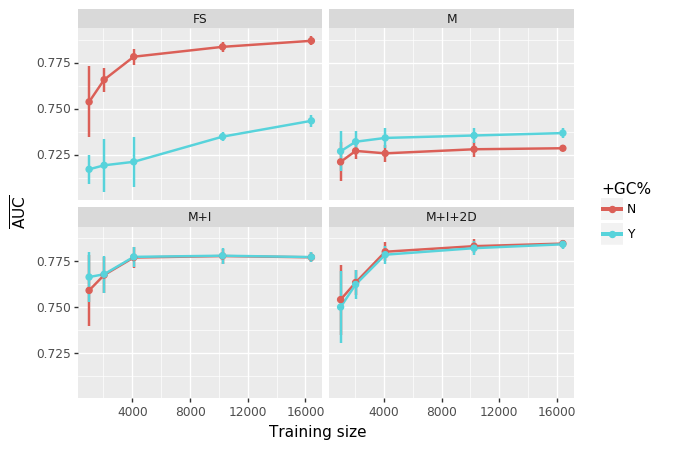

<ggplot: (7547534193)>


In [31]:
clfs = {'LR':'N', 'LR_GC':'Y'}
dims = [0, 1, 2, 6]

gc_lc_aucs = []
for dim in dims:
    data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/%s_way_samples/train_size_*/" % dim)
    for clf in clfs:
        sample_aucs = []
        for directory in data_dirs:
            aucs = get_auc(directory, sample_aucs, clf)
        sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
        
        for r in sort_aucs:
            dim = r[0]
            train_size = r[1]
            auc = float(r[2])
            gc = r[3]
            
            gc_lc_aucs.append([model_nm_dict[dim], train_size, auc, clfs[gc]])

models = set(r[0] for r in gc_lc_aucs)
train_sizes = set(r[1] for r in gc_lc_aucs)
gc_groups = set(r[3] for r in gc_lc_aucs)
n = 5
records = []
for model in models:
    for train_size in train_sizes:
        for gc in gc_groups:
            auc_list = []
            for r in gc_lc_aucs:
                if model not in r:
                    continue
                if train_size not in r:
                    continue
                if gc != r[3]:
                    continue
                auc_list.append(r[2])
            
            auc_mean = np.array(auc_list).mean()
            auc_se = np.array(auc_list).std(ddof=1)
            records.append([model, train_size, gc, auc_mean, auc_se])
    
h = ['Classifier', 'Training_size', '+GC%', 'Mean_AUC', 'Std_error']
gc_lc_tab = LoadTable(header=h, rows=records)
gc_lc_df = gc_lc_tab.to_pandas_df()
faceted_gc_lc = (ggplot(gc_lc_df) +
                aes(x="Training_size", y="Mean_AUC", colour='+GC%', group='+GC%') +
                geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
                geom_line(size=1) +
                geom_point(size=2) +
                labs(x="Training size", y="$\overline{\mathrm{AUC}}$") +
                facet_wrap(' ~ Classifier'))

outfig_name = "gc_vs_nogc_curve.pdf"
faceted_gc_lc.save("figs_n_tabs/%s" % outfig_name, units="cm", width=20, height=16)
print ("%s is saved!" % outfig_name)
print (faceted_gc_lc)
all_supp_dict["supfig:gc_vs_nogc_curve"] = r"""\begin{figure}[ht]
  \centering
  \includegraphics[width=1.0\textwidth]{figs/gc_vs_nogc_curve.pdf}
  \caption{Inclusion of GC\% reduced performance when categorical neighbourhood features were included. The classifier including the GC\% feature is indicated by a +GC\% value of Y. The value N corresponds to the classifier with the strictly categorical feature set.}
  \label{supfig:gc_vs_nogc_curve}
\end{figure}
"""

## Supp. figures: AUC scores comparison between the logistic regression classifier and the NB classifier - chrom1

M+I+2D_lr_v_nb_curve.pdf is saved!


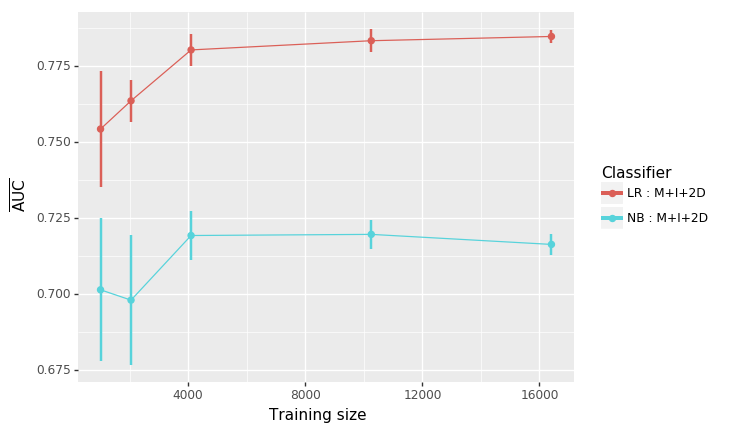

<ggplot: (-9223372036566970701)>


In [32]:
clfs = {'LR', 'NB'}

lr_v_nb_rows = []
data_dirs = glob.glob("classifier/results/chrom1/7-mer/data_ratio_1/direction_All/2_way_samples/train_size_*/")
    
for clf in clfs:
    sample_aucs = []
    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, clf)
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        classifier = r[3]
            
        lr_v_nb_rows.append([model_nm_dict[dim], train_size, auc, classifier])

models = set(r[0] for r in lr_v_nb_rows)
train_sizes = set(r[1] for r in lr_v_nb_rows)
clf_groups = set(r[3] for r in lr_v_nb_rows)
n = 5

chrom1_nb_dict = {}
for model in models:
    lr_v_nb_records = []
    for train_size in train_sizes:
        for clf in clf_groups:
            auc_list = []
            for r in lr_v_nb_rows:
                if model not in r:
                    continue
                if train_size not in r:
                    continue
                if clf not in r:
                    continue
                auc_list.append(r[2])
    
            auc_mean = np.array(auc_list).mean()
            auc_se = np.array(auc_list).std(ddof=1)
            clf_nm = '%s : %s'%(clf, model)
            
            chrom1_nb_dict[model] = auc_mean
            lr_v_nb_records.append([clf_nm, train_size, auc_mean, auc_se])
    
    lr_v_nb_h = ['Classifier', 'Training_size', 'Mean_AUC', 'Std_error']
    lr_v_nb_tab = LoadTable(header=lr_v_nb_h, rows=lr_v_nb_records)
    lr_v_nb_df = lr_v_nb_tab.to_pandas_df()
    fig_lr_v_nb = (ggplot(lr_v_nb_df) + 
                   aes(x="Training_size", y="Mean_AUC", colour="Classifier") +
                   geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
                   geom_line(size=0.5) +
                   geom_point(size=2) +
                   labs(x="Training size", y="$\overline{\mathrm{AUC}}$"))
    
    outfig_name = "%s_lr_v_nb_curve.pdf" % model
    fig_lr_v_nb.save("figs_n_tabs/%s" % outfig_name, units="cm", width=20, height=16)
    print ("%s is saved!" % outfig_name)
    print (fig_lr_v_nb)

all_supp_dict["supfig:M+I+2D_lr_v_nb_curve"] = r"""\begin{figure}[!ht]
  \centering
  \includegraphics[width=1.0\textwidth]{figs/M+I+2D_lr_v_nb_curve.pdf}
  \caption{The Logistic Regression classifier performed better than the Na\"ive Bayes classifier. x-axis is the size of 
  the training sample, y-axis is the mean AUC and error bars were calculated from the 5 chromosome 1 training samples.}
  \label{supfig:M+I+2D_lr_v_nb_curve}
\end{figure}
"""

## Supp. figure: 61-mer learning curve indicates a larger neighbourhood improve the classification results.

    k  Training_size  Mean_AUC  Std_error
0   7           2050  0.767597   0.009677
1   7           4101  0.777101   0.005645
2   7          10255  0.777899   0.004066
3   7           1009  0.759204   0.019283
4   7          16408  0.777219   0.002822
5  61           2050  0.788494   0.003340
6  61           4101  0.802480   0.001739
7  61          10255  0.811159   0.001442
8  61           1009  0.764965   0.002136
9  61          16408  0.813576   0.001783
figs_n_tabs/lf_learning_curve.pdf is saved!


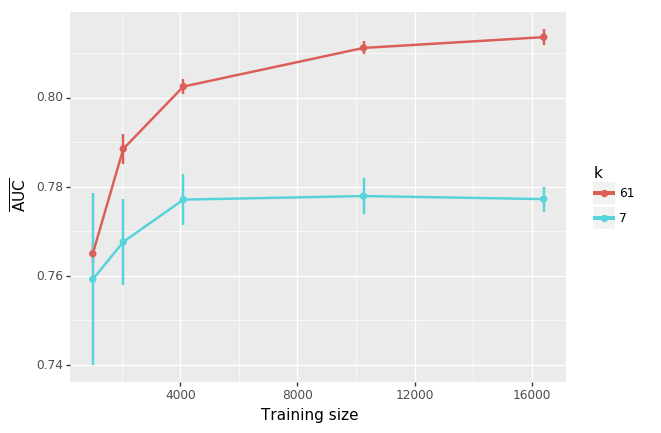

<ggplot: (7547515291)>


In [33]:
lf_lc_aucs = []    
k_sizes = [7, 61]

for k_sz in k_sizes:
    data_dirs = glob.glob("classifier/results/chrom1/%s-mer/data_ratio_1/direction_All/1_way_samples/train_size_*/" % k_sz)
    
    sample_aucs = []

    for directory in data_dirs:
        aucs = get_auc(directory, sample_aucs, 'LR')
    sort_aucs = sorted(sample_aucs, key = lambda x: int(x[1]))
    for r in sort_aucs:
        dim = r[0]
        train_size = r[1]
        auc = float(r[2])
        lf_lc_aucs.append([k_sz, train_size, auc])

train_sizes = set(r[1] for r in lf_lc_aucs)
n = 5

lf_auc_records = []
for k_sz in k_sizes:
    for train_size in train_sizes:
        auc_list = []
        for r in lf_lc_aucs:
            if k_sz not in r:
                continue
            if train_size not in r:
                continue
            auc_list.append(r[2])
        auc_mean = np.array(auc_list).mean()
        auc_se = np.array(auc_list).std(ddof=1)
        
        lf_auc_records.append(['%s'%k_sz, train_size, auc_mean, auc_se]) 

h = ['k', 'Training_size', 'Mean_AUC', 'Std_error']
lf_tab = LoadTable(header=h, rows=lf_auc_records).to_pandas_df()
print (lf_tab)
lf_fig = (ggplot(lf_tab) +
     aes(x="Training_size", y="Mean_AUC", colour="k") +
     geom_errorbar(aes(ymin="Mean_AUC-Std_error", ymax="Mean_AUC+Std_error"), width=.1, size=1) +
     geom_line(size=1) +
     geom_point(size=2) +
     labs(x="Training size", y="$\overline{\mathrm{AUC}}$")
       )

outname = "figs_n_tabs/lf_learning_curve.pdf"
lf_fig.save(outname, units="cm", width=20, height=16)
print ("%s is saved!" % outname)
print (lf_fig)

all_supp_dict["supfig:lc_61mer_vs_7mer"] = r"""\begin{figure}[ht]
  \centering
  \includegraphics[width=1.0\textwidth]{figs/lf_learning_curve.pdf}
  \caption{The LR classifiers for 61-mer performed better than the 7-mer. x-axis is the size of the training sample, y-axis is the mean AUC obtained from implementing the M+I model, and error bars were calculated from the 5 chromosome 1 training samples.}
  \label{supfig:lc_61mer_vs_7mer}
\end{figure}
"""

# Save all supplementary figs and tables into a .tex file

Define some utility functions first.

In [34]:
from collections import OrderedDict
import os
import re

ref = re.compile(r"\\ref\{[^\}]+\}")
label = re.compile(r"\\label{\S+}")

def get_tags(filepath, tag):
    """returns the set of tags from a latex file.
    
    tag can be either label or ref"""
    pattern = {"label": label, "ref": ref}[tag]
    with open(filepath) as infile:
        data = "".join(infile.readlines())
    
    all_tags = pattern.findall(data)
    all_tags = [t.split('{')[-1][:-1] for t in all_tags]
    #  we ignore equation tags
    all_tags = [(t, filepath) for t in all_tags if not t.startswith('eq:')]
    return OrderedDict(all_tags)

def split_main_supp_tags(tags):
    """splits the labels into those for the main manuscript and for the supplementary"""
    supp_tags = OrderedDict()
    main_tags = OrderedDict()
    for tag in tags:
        store = supp_tags if tag.startswith("sup") else main_tags
        store[tag] = tags[tag]
    return main_tags, supp_tags

load the supp material latex template file

In [35]:
with open("../mutation_classifier_manuscript/supp_template.tex") as infile:
    supp_text = infile.readlines()
    insert_index = [i for i, t in enumerate(supp_text) if "BODY" in t][0]

get all the latex files from the maunscript directory, which we assume is a sister directory to this ENUProject

In [36]:
# hardcoding these, in the manuscript order of the sections
texdir = "../mutation_classifier_manuscript"
texfns = [os.path.join(texdir, tfn) for tfn in ("introduction.tex", "results.tex", "discussion.tex", "methods.tex")]
alllabels = None
for tfn in texfns:
    tags = get_tags(tfn, "label")
    if alllabels is None:
        alllabels = tags
    else:
        alllabels.update(tags)

allrefs = None
for tfn in texfns:
    tags = get_tags(tfn, "ref")
    if allrefs is None:
        allrefs = tags
    else:
        allrefs.update(tags)

mainrefs, suprefs = split_main_supp_tags(allrefs)

In [37]:
missing = set(alllabels) - set(mainrefs)
for missed in missing:
    print("## The following labels are not referenced (possibly subtable/fig?)", missed, alllabels[missed])

## The following labels are not referenced (possibly subtable/fig?) tab:one-hot ../mutation_classifier_manuscript/methods.tex
## The following labels are not referenced (possibly subtable/fig?) tab:mutation-seq-example ../mutation_classifier_manuscript/methods.tex
## The following labels are not referenced (possibly subtable/fig?) fig:flow_chart-two-class ../mutation_classifier_manuscript/methods.tex
## The following labels are not referenced (possibly subtable/fig?) fig:flow_chart-one-class ../mutation_classifier_manuscript/methods.tex


In [38]:
body = []
for tag in suprefs:
    if tag not in all_supp_dict:
        print("## Missing", tag, suprefs[tag])
        continue
    body.append(all_supp_dict[tag])

## Adding the Naive Bayes comparison to LR at the end, as this is not directly referenced from the main manuscript

In [39]:
body.extend([all_supp_dict['supfig:M+I+2D_lr_v_nb_curve']])

## Writing all supp contents

Copy the contents of `../mutation_classifier_manuscript/supp_material_generated.tex` to the Supplementary_material.tex file on ShareLatex.

In [40]:
supp_text[insert_index] = "\n".join(body)
with open("../mutation_classifier_manuscript/supp_material_generated.tex", "w") as out:
    out.write("".join(supp_text))